In [27]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
os.chdir('/home/ak431480')

# Date: 16.1.2026
# Analyzing NEOADJUVANT FFPE cell2location celltype mapping results

In [28]:
sample_sheet = pd.read_excel('/home/ak431480/sample_sheet_neadt.xlsx')
samples = sample_sheet['SAMPLE_PAD'].tolist()


## Load spatial data with cell2location mapping results
def load_slide(sample, path='/scratch/svc_td_compbio/users/kiviaho/neoadjuvant_ffpe_visium/normalized_h5ads/'):
    slide = sc.read_h5ad(f'{path}{sample}_normalized.h5ad')
    return slide

In [29]:

spatial_data = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/neoadjuvant_ffpe_visium/c2l_dir/cell2location_map/sp.h5ad')
spatial_data.obs[spatial_data.uns['mod']['factor_names']] = spatial_data.obsm['q05_cell_abundance_w_sf'] # Extract the 5% quantile from the posterior distribution

spatial_data.obs = spatial_data.obs.drop(columns=['Epithelial cell_9','Epithelial cell_11'])

# Map sample annotation
spatial_data.obs = pd.merge(sample_sheet.set_index('SAMPLE_PAD'), spatial_data.obs,left_index=True,right_on='sample_id')
spatial_data.obs['treatment'] = pd.Categorical(spatial_data.obs['TREATMENT'],categories=['none','goserelin','bicalutamide'])
spatial_data.obs['treatment_simple'] = pd.Categorical(spatial_data.obs['treatment'].map({'none':'naive','goserelin':'exposed','bicalutamide':'exposed'}),categories=['naive','exposed'])

# Celltype_annotation
celltype_annotation_df = pd.read_excel('./single_cell_celltype_annotation.xlsx',index_col=0)
celltype_annot_dict = celltype_annotation_df.to_dict()['celltype name']

# Create obs data df
obs_data_df = spatial_data.obs.copy()
obs_data_df.columns = obs_data_df.columns.str.replace(r'\.0$', '', regex=True) # Strip trailing .0

celltypes = obs_data_df.columns[20:-2].tolist()
celltypes = obs_data_df[celltypes].mean().sort_values(ascending=False).index.to_list()

celltype_names = (
    spatial_data.obsm['q05_cell_abundance_w_sf']
    .columns
    .str.removeprefix('q05cell_abundance_w_sf_')
)

In [30]:
def summarize_by_broad_celltype(df, celltypes):
    """
    Summarize columns in `df` by their broad cell type.
    Example: Epithelial cell_0, Epithelial cell_1 → Epithelial cell
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing cell-type columns.
    celltypes : list
        List of column names to summarize.
    
    Returns
    -------
    pd.DataFrame
        A dataframe with one column per broad cell type, values summed row-wise.
    """
    
    # Extract the broad cell type before the last underscore part
    broad_map = {ct: '_'.join(ct.split('_')[:-1]) for ct in celltypes}
    
    grouped = {}
    for broad in set(broad_map.values()):
        cols = [ct for ct, b in broad_map.items() if b == broad]
        grouped[broad] = df[cols].sum(axis=1)
    
    summarized_df = pd.DataFrame(grouped)
    return summarized_df


# --- Example usage ---
broad_summary = summarize_by_broad_celltype(obs_data_df, celltypes)

broad_celltypes = broad_summary.columns.tolist()
# Concatenate the summarized data on axis=1
obs_data_df = pd.concat([obs_data_df, broad_summary], axis=1)

# Reorder broad_celltypes by abundance

broad_celltypes = obs_data_df[broad_celltypes].describe().loc['mean'].T.sort_values(ascending=False).index.tolist()
obs_data_df[broad_celltypes].describe()


,Fibroblast,Epithelial cell,Myeloid cell,Endothelial cell,T cell,Mast cell,B cell
count,55226.000000,55226.000000,55226.000000,55226.000000,55226.000000,55226.000000,55226.000000
mean,7.108620,3.665515,0.631471,0.578166,0.553022,0.551413,0.530869
std,7.104328,3.700830,0.992701,0.663810,0.738022,0.553476,0.702906
min,0.002790,0.010690,0.003407,0.001018,0.002688,0.001139,0.001024
25%,2.045529,0.636514,0.181276,0.232118,0.230033,0.199945,0.211038
50%,4.985108,2.674594,0.343348,0.408011,0.360396,0.392209,0.352524
75%,10.365054,5.541186,0.678290,0.670931,0.586180,0.737156,0.592600
max,100.376067,35.934318,23.406302,14.761540,18.551492,12.174408,19.937541


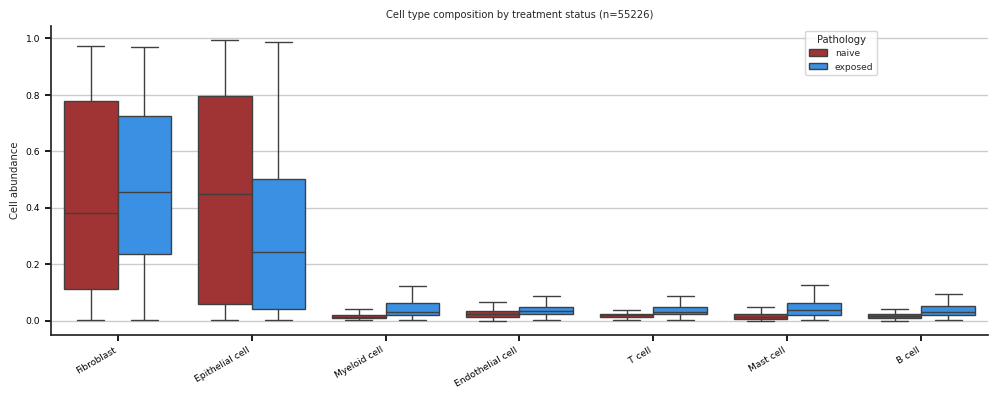

In [31]:

sns.set_theme(
    style='white',
    font_scale=0.6,
    rc={
        'xtick.bottom': True,
        'ytick.left': True,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'xtick.color': 'black',
        'ytick.color': 'black'
    }
)
plot_df = obs_data_df[(obs_data_df['treatment_simple'] != 'nan') ].copy()
plot_df['treatment_simple'] = plot_df['treatment_simple'].cat.remove_unused_categories()
n_cells = len(plot_df)
# Normalize each spot by total number of cells
row_sums = plot_df[broad_celltypes].sum(axis=1)
plot_df[broad_celltypes] = plot_df[broad_celltypes].div(row_sums.replace(0, np.nan), axis=0)

colors = {
    'naive': 'firebrick',
    'exposed': 'dodgerblue',
}

# Reshape to long format for seaborn
plot_df = plot_df.melt(
    id_vars='treatment_simple',
    value_vars=broad_celltypes,
    var_name='Cell type',
    value_name='Abundance'
)

# Create the violin plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(
    data=plot_df,
    x='Cell type',
    y='Abundance',
    hue='treatment_simple',
    palette=colors,
    fliersize=0,
    ax=ax
    #cut=0,
    #inner='box'
)


plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('Cell abundance')
plt.title(f'Cell type composition by treatment status (n={n_cells})')
plt.legend(title='Pathology', bbox_to_anchor=(0.8, 1), loc='upper left')
plt.grid(axis='y')
sns.despine()
plt.tight_layout()
#plt.savefig('./plots/shafi_broad_celltype_fractions_split_by_pathology_groups.png',dpi=120)
plt.show()


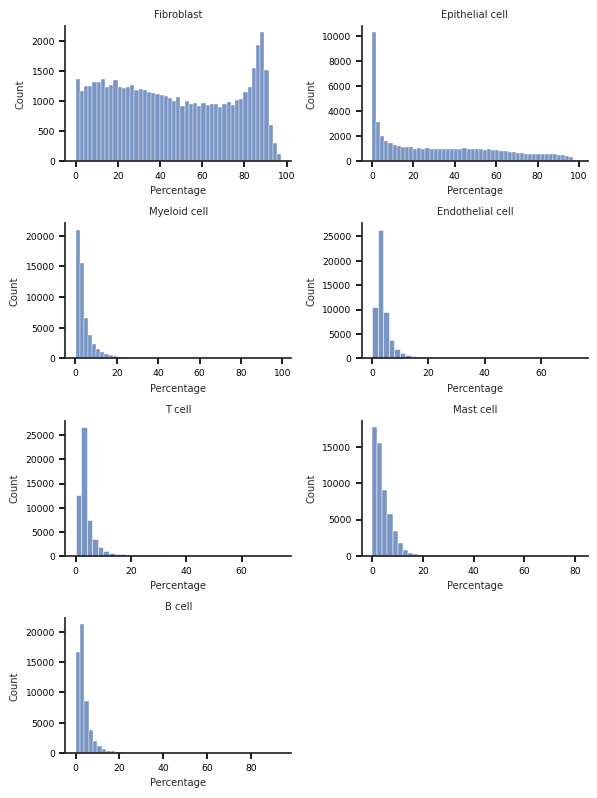

In [32]:

plot_df = obs_data_df[broad_celltypes].copy()
plot_df = plot_df.div(plot_df.sum(axis=1),axis=0)*100

fig,axs = plt.subplots(4,2,figsize=(6,8))

axs = axs.ravel()
for i,ctype in enumerate(broad_celltypes):
    sns.histplot(plot_df[ctype],binwidth=2,ax=axs[i])
    axs[i].spines[['top','right']].set_visible(False)
    axs[i].set_title(ctype)
    axs[i].set_xlabel('Percentage')

axs[i+1].set_visible(False)
plt.tight_layout()
plt.show()

stroma_below_pctage_threshold = plot_df[plot_df['Fibroblast'] < 75].index.tolist()

In [40]:
len(stroma_below_pctage_threshold)/len(spatial_data)

0.7661789736718212

In [33]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting

sns.set_theme(
    style='whitegrid',
    font_scale=0.6,
    rc={
        'xtick.bottom': True,
        'ytick.left': True,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'xtick.color': 'black',
        'ytick.color': 'black'
    }
)

# All samples
for sample in samples[:1]:

       slide = load_slide(sample)
       
       #### REMOVE THIS ONCE SPOT INTERSECTION ISSUE IS RESOLVED
       spot_intersection = obs_data_df.index.intersection(slide.obs_names)
       slide = slide[spot_intersection]
       slide.obs = obs_data_df.loc[spot_intersection].copy()

       celltypes_slide = slide.obs[celltypes].mean().sort_values(ascending=False).index.to_list()
       slide.obs = slide.obs.rename(columns=celltype_annot_dict)
       
       # plot in spatial coordinates
       with mpl.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [3.3, 3]}):

              fig = sc.pl.spatial(
              slide,
              cmap='magma',
              color=[celltype_annot_dict[k] for k in celltypes_slide[:8]],
              #color=[k for k in celltypes_slide[:8]],
              ncols=4,
              size=1.3,
              img_key='lowres',
              vmin=0,
              vmax='p99.2',
              show=False,        # 👈 important
              return_fig=True    # 👈 return the figure instead of showing it
              )
       sampletype = sample_sheet.loc[sample_sheet['SAMPLE_PAD'] == sample,'TREATMENT'][0]
       fig.suptitle(f'{sample} ({sampletype})')  # 👈 add title to that figure
       plt.xlabel(None)
       plt.ylabel(None)
       fig.tight_layout()
       fig.savefig(f'./plots/celltype_abundance_spatial/{sample}_top8_abundant_celltypes_on_spatial.pdf')
       #plt.show()
       plt.clf()



/tmp/ipykernel_62209/2923791516.py:34: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(
/tmp/ipykernel_62209/2923791516.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1646.4x600 with 0 Axes>

## Pre / post-treatment

In [34]:
df_for_plotting = obs_data_df.rename(columns=celltype_annot_dict)
celltype_names = celltype_annotation_df[((celltype_annotation_df['broad celltype'] == 'Epithelial cell') & (celltype_annotation_df['celltype name'] != 'drop'))]['celltype name'].tolist()

df_for_plotting = df_for_plotting[['sample_id','PATIENT','treatment_simple'] + celltype_names]
df_for_plotting = df_for_plotting.loc[stroma_below_pctage_threshold]

df_for_plotting[celltype_names].divide(df_for_plotting[celltype_names].sum(axis=1))

X = df_for_plotting[celltype_names]
df_norm = X.div(X.sum(axis=1), axis=0) * 100
df_for_plotting[celltype_names] = df_norm[celltype_names]


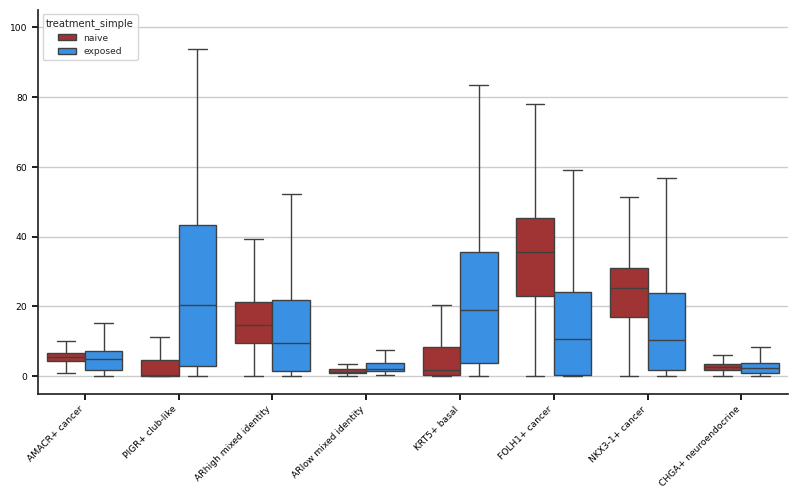

In [35]:
plot_df = df_for_plotting.melt(
    id_vars='treatment_simple',
    value_vars=celltype_names,
    var_name='celltype',
    value_name='value'
)

sns.set_theme(
    style='white',
    palette=sns.color_palette(['firebrick', 'dodgerblue']),
    font_scale=0.6,
    rc={
        'xtick.bottom': True,
        'ytick.left': True,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'xtick.color': 'black',
        'ytick.color': 'black'
    }
)

fig, ax = plt.subplots(figsize=(1 * len(celltype_names), 5))

sns.boxplot(
    data=plot_df,
    x='celltype',
    y='value',
    hue='treatment_simple',
    fliersize=0,
    ax=ax
)

ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y')
ax.set_ylim(-5, 105)
ax.set_xlabel('')
ax.set_ylabel('')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Sample-specific pre/post

/tmp/ipykernel_62209/1868515285.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["PATIENT", "treatment_simple"], as_index=False)[sig]
/tmp/ipykernel_62209/1868515285.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["PATIENT", "treatment_simple"], as_index=False)[sig]
/tmp/ipykernel_62209/1868515285.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["PATIENT", "treatment_simple"], a

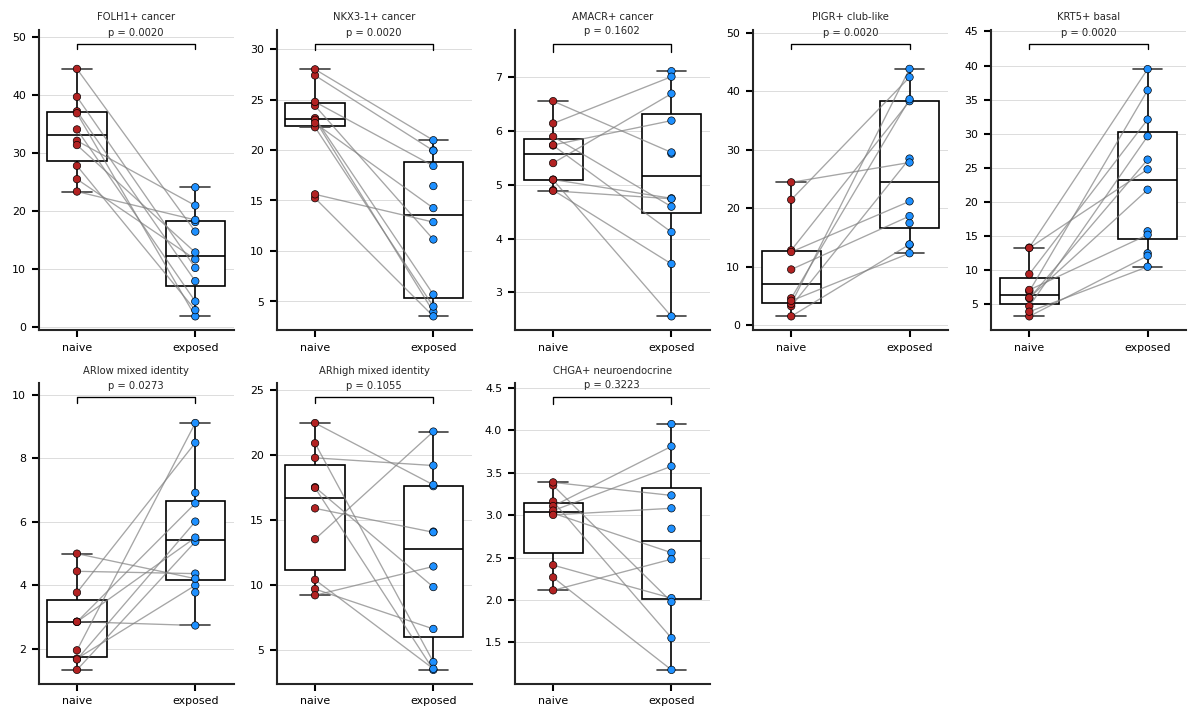

In [37]:
from scipy.stats import wilcoxon
n_rows = 2
n_cols = 5

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 2, n_rows * 3),
    dpi=120,
    sharey=False
)

axes = axes.flatten()
genesets_important = [
    'FOLH1+ cancer',
    'NKX3-1+ cancer',
    'AMACR+ cancer',
    'PIGR+ club-like',
    'KRT5+ basal',
    'ARlow mixed identity',
    'ARhigh mixed identity',
    'CHGA+ neuroendocrine'
    ]


for ax, sig in zip(axes, genesets_important):

    # -----------------------------
    # Patient-level mean per treatment
    # -----------------------------
    df_mean = (
        df_for_plotting
        .groupby(["PATIENT", "treatment_simple"], as_index=False)[sig]
        .mean()
    )

    # -----------------------------
    # Paired Wilcoxon signed-rank
    # -----------------------------
    df_wide = (
        df_mean
        .pivot(index="PATIENT", columns="treatment_simple", values=sig)
        .dropna()
    )

    treatments = df_wide.columns.tolist()
    stat, pval = wilcoxon(
        df_wide[treatments[0]],
        df_wide[treatments[1]]
    )

    # -----------------------------
    # Boxplot
    # -----------------------------
    sns.boxplot(
        data=df_mean,
        x="treatment_simple",
        y=sig,
        ax=ax,
        width=0.5,
        showcaps=True,
        boxprops=dict(facecolor="white", edgecolor="black"),
        whiskerprops=dict(color="black"),
        medianprops=dict(color="black"),
        flierprops=dict(marker=""),
        zorder=1,
    )

    # Points
    sns.scatterplot(
        data=df_mean,
        x="treatment_simple",
        y=sig,
        hue="treatment_simple",
        s=20,
        ax=ax,
        linewidth=0.4,
        edgecolor="black",
        zorder=3,
        legend=False,
    )

    # Paired lines
    for patient, d in df_mean.groupby("PATIENT"):
        if d["treatment_simple"].nunique() > 1:
            ax.plot(
                d["treatment_simple"],
                d[sig],
                color="gray",
                alpha=0.7,
                linewidth=0.8,
                zorder=2,
            )

    # -----------------------------
    # Wilcoxon annotation
    # -----------------------------
    y_min, y_max = df_mean[sig].min(), df_mean[sig].max()
    y = y_max + 0.08 * (y_max - y_min)

    ax.plot(
        [0, 0, 1, 1],
        [y, y * 1.02, y * 1.02, y],
        lw=0.8,
        color="black",
    )

    ax.text(
        0.5,
        y * 1.04,
        f"p = {pval:.4f}",
        ha="center",
        va="bottom",
        fontsize=6,
    )

    # -----------------------------
    # Aesthetics
    # -----------------------------
    ax.set_title(sig, fontsize=6)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_axisbelow(True)
    ax.grid(axis="y", linewidth=0.4)

# Hide unused axes (if any)
for ax in axes[len(genesets_important):]:
    ax.axis("off")

plt.tight_layout()
#plt.savefig('/home/ak431480/plots/neoadj_signature_score_boxplots_celltypes_important.pdf')
plt.show()
